# 1. SDKを使ってサーバーのデータを加工してみよう

このチュートリアルでは、Utility ToolsでアップロードしたCSVデータを **intdash SDK for Python**  （以下、 intdash SDKと呼びます）を使用して取得し、Pythonの一般的なライブラリーを用いて可視化および加工処理を行います。加工したデータは、再度intdashにアップロードし **Visual M2M Data Visualizer** （以下、Data Visualizerと呼びます） で加工前と加工後のデータを比較します。

- intdashにアップロードしたデータを取得する
- 取得したデータを `matplotlib` で可視化する
- 取得したデータを加工して、intdashにアップロードする

## 1.0 事前準備
本シナリオを実施する前に、以下を用意する必要があります。

- 計測用のエッジ
- CSVをアップロードすることによって作成された計測データ


### 使用データ
本チュートリアルでは、以下のデータをサーバー側に準備する必要があります。
本項では以下のデータ名で処理を実施しています。

|データ項目|本シナリオで登場するデータ名|
|:---|:---|
|時系列データを登録するエッジ|edge1|
|計測データ| measurement1 |


### 計測データの作成と時系列データのアップロード
本チュートリアルでは、intdashにCSVデータをアップロードした状態から始める必要があります。CSVデータをアップロードする方法については、 **intdashチュートリアル1の 「2.2 CSVファイルをアップロードする」** を参照してください。本項では、以下のCSVをアップロードしたものとして実施します。


<img src="https://user-images.githubusercontent.com/70192465/94385037-0c135500-017f-11eb-9667-781a067e0ec6.png">

Data Visualizerの[Stored Data]に計測が表示されていれば、計測データの準備は完了です。
この後、この計測データに対して加工を行います。

<img src="https://user-images.githubusercontent.com/70192465/94385045-103f7280-017f-11eb-8f12-30df59079069.png">

### パッケージのimportとクライアントの生成
`intdash.Client` に与える `url` は intdashサーバーの環境情報から、`username` と `password` はログイン用エッジで発行したアクセス情報を指定してください。  

In [2]:
import pandas as pd

import intdash
from intdash import timeutils

# Create client

client = intdash.Client(
    url = "https://example.intdash.jp",
    username = "edge1",
    password="password_here"
)

以上で事前準備は終了です。

## 1.1 計測に使用したエッジを取得する
まず最初に、CSVデータをアップロードした際に使用したエッジアカウントを取得します。

In [3]:
edges = client.edges.list(name='edge1')
edge1 = edges[0]

In [4]:
edge1.name

'edge1'

## 1.2 計測を取得する
``start`` と ``end`` で時間範囲を指定して `list()` を実行し、計測のリストを取得します。


In [5]:
ms = client.measurements.list(
    edge_uuid=edge1.uuid,
    start=timeutils.str2timestamp('2020-07-17 00:00:00+09:00'),
    end=timeutils.str2timestamp('2020-07-18 00:00:00+09:00')
)

In [6]:
# Because there is only one measurement associated with `edge1`, the index 0 is specified.
measurement1 = ms[0]
print(measurement1)

uuid: 04ef53ac-f0db-410a-b871-ebc0de9ce19d
name: 
description: 
edge_uuid: 6856e10c-e639-46bd-9246-b3e85f991107
duration: 0 days 00:00:51.445358
ended: True
basetime: 2020-07-17 01:21:45.911747+00:00
basetime_type: edge_rtc
processed_ratio: 1
protected: True
markers: []
created_at: 2020-08-12 09:25:12.837525+00:00
updated_at: 2020-08-12 09:25:21.446317+00:00


## 1.3 時系列データを取得する
時系列データの取得には `client.data_points` エンドポイントを使用します。  
ここでは加速度データ(``sp_ACCX`` , ``sp_ACCY`` , ``sp_ACCZ`` )のみを対象にします。

データを指定するには、 ``id_queries`` パラメーターにて ``data_id`` を指定します。 ``data_id`` は、CSVの1行目に記載されているヘッダーの文字列です。（今回のケースでは、``sp_ACCX`` , ``sp_ACCY`` , ``sp_ACCZ`` を指定します）

In [7]:
dps = client.data_points.list(
    edge_name='edge1',
    start=timeutils.str2timestamp('2020-07-17 00:00:00+09:00'),
    end=timeutils.str2timestamp('2020-07-18 00:00:00+09:00'),
    id_queries=[
        intdash.IdQuery(
            data_id= 'sp_ACCX'
        ),
        intdash.IdQuery(
            data_id= 'sp_ACCY'
        ),
        intdash.IdQuery(
            data_id= 'sp_ACCZ'
        )
    ],
    limit=0
)

実行すると、以下のようにデータポイントが取得されます。データの中身を確認することができます。

In [8]:
print(dps[0])

time: 2020-07-17T01:21:45.911747000Z
measurement_uuid: 04ef53ac-f0db-410a-b871-ebc0de9ce19d
data_type: 11
channel: 1
data_id: sp_ACCX
data_payload: b'\x07sp_ACCX\xa0m5\xeb\x8c\xef\xa3?'


## 1.4 取得したデータを可視化する

取得した時系列データをPythonの一般的なライブラリーを用いて可視化します。  
今回は可視化に、 `matplotlib` を使用し、折れ線グラフとして表示します。    

まず、取得したデータを `pandas.DataFrame` 形式に変換します。
以下のように指定することで、 ``data_id`` ごとのカラムを持つDataFrameに変換することができます。

In [9]:
from intdash import data

df = pd.DataFrame( [ {
     'time' : d.time,
       d.data_id : data.Float.from_payload(d.data_payload).value # convert binary to numbers.
    }
    for d in dps
]).groupby("time").last()

df

,sp_ACCX,sp_ACCZ,sp_ACCY
time,,,
2020-07-17T01:21:45.911747000Z,0.038937,0.205379,0.491985
2020-07-17T01:21:45.931913000Z,0.139753,-0.064305,0.429696
2020-07-17T01:21:45.952079000Z,0.102823,-0.076985,0.398769
2020-07-17T01:21:45.972245000Z,0.046802,-0.009198,0.320168
2020-07-17T01:21:45.992411000Z,0.009810,-0.049083,0.294638
...,...,...,...
2020-07-17T01:22:37.276434000Z,0.295249,0.202644,0.019525
2020-07-17T01:22:37.296602000Z,0.090947,-0.114039,0.020039
2020-07-17T01:22:37.316769000Z,-0.232320,-0.398277,-0.185733


データをpandas.DataFrameに変換できたら、 早速 `matplotlib` の `pyplot` を用いてデータを描画します。  
描画した結果、以下のように表示されます。

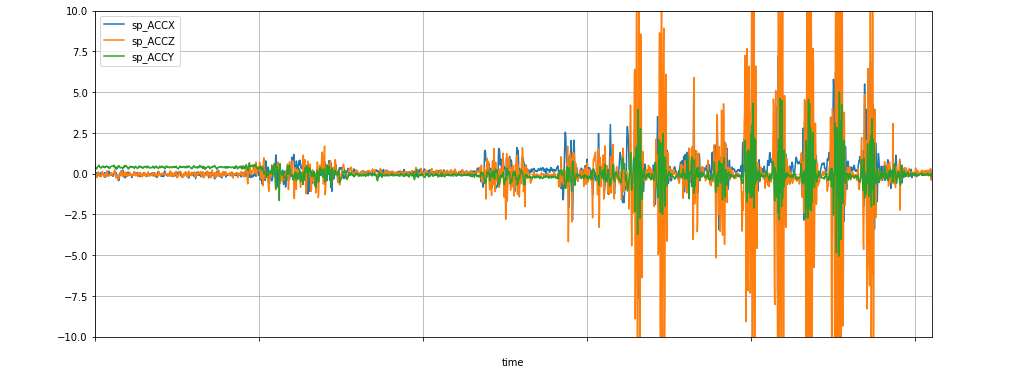

In [10]:
from matplotlib import pyplot as plt

df.plot(figsize=(15,6), grid=True, ylim=[-10, 10])

plt.xticks(color="None")
plt.show()
plt.close()

## 1.5 取得したデータを加工する
次に、取得したデータに対して関数処理を実行し、データの変化を観察します。
関数処理のサンプルとして移動平均を使用します。

### 1.5.1 関数処理を行う
移動平均を算出してサーバー側に返す処理を定義します。移動平均は、 `numpy` の `convolve` を使用して算出します。

In [11]:
import numpy as np

num = 5
b=np.ones(num)/num

conv_df = pd.DataFrame( index=df.index)
conv_df['cov_ACCX'] = np.convolve(df['sp_ACCX'], b, mode='same')
conv_df['cov_ACCY'] = np.convolve(df['sp_ACCY'], b, mode='same')
conv_df['cov_ACCZ'] = np.convolve(df['sp_ACCZ'], b, mode='same')

### 1.5.2 加工後のデータを確認する
加工後のデータの変化を確認するため、再度 `matplotlib` で可視化します。

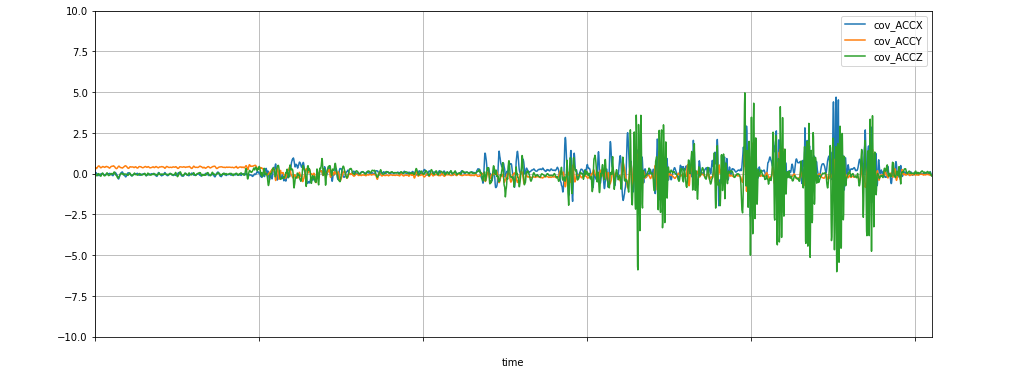

In [12]:
conv_df.plot(figsize=(15,6), grid=True, ylim=[-10, 10])

plt.xticks(color="None")
plt.show()
plt.close()

移動平均のグラフは、元のグラフよりなめらかになっていることが分かります。

## 1.6 加工したデータをintdashにアップロードする
最後に、加工したデータをintdashにアップロードします。移動平均のデータを、時系列データのフォーマットに変換します。

まず、今回加工したデータに紐付けるための計測を作成します。計測の開始時刻として、データの最初の時刻を指定します。

In [13]:
new_measurements = client.measurements.create(
    basetime=timeutils.str2timestamp(dps[0].time), #  The start time specifies the time of  first data.
    edge_uuid=edge1.uuid
)

DataFrameを、時系列データのアップロード形式である `DataPoint` に変換します。

In [14]:
datapoints = []

for data_id, values in conv_df.to_dict().items():
    for time, value in values.items():
        datapoints.append(
            intdash.DataPoint(
                elapsed_time= timeutils.str2timestamp(time) - new_measurements.basetime, # Time elapsed from the start of measurement.
                data_type=intdash.DataType.float,
                channel=1, # fixed at 1.
                data_payload=intdash.data.Float(data_id=data_id, value=value).to_payload()
            )
        )

変換が完了したら、先程作成した計測に時系列データを紐付けます。

In [15]:
client.data_points.store(
    measurement_uuid=new_measurements.uuid,
    data_points=datapoints
)

これでアップロードは完了です。以下のように Data Visualizerでデータを確認することができます。可視化の詳細については、 **intdash チュートリアル1の「2.3 アップロードしたデータをダッシュボードで可視化する」** も参考にしてください。

<img src="https://user-images.githubusercontent.com/70192465/94385041-0d448200-017f-11eb-8629-75acf537797f.png">